# Importar Librerías

In [1]:
import joblib  

In [2]:
root = '/content/temp_drive'

In [3]:
from google.colab import drive
drive.mount(root)

Mounted at /content/temp_drive


In [4]:
%cd "{root}/MyDrive/monografia_UDEA/Codigo"

/content/temp_drive/MyDrive/monografia_UDEA/Codigo


In [5]:
%run 00_configuracion_entorno.ipynb

     |████████████████████████████████| 1.4 MB 21.8 MB/s 
     |████████████████████████████████| 9.8 MB 57.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
/content/temp_drive/MyDrive/monografia_UDEA


## **Carga de archivo fuentes**

Se realiza el proceso de carga de los archivos correspondiente a cada moneda de análisis

In [6]:
%cd "{root}/MyDrive/monografia_UDEA/Salidas"

/content/temp_drive/MyDrive/monografia_UDEA/Salidas


In [10]:
%ls

bitcoinOpen_ajustado_diff_media.jpg
bitcoinOpen_ajustado_diff_Std.jpg
bitcoinOpen_ajustado_Normalizados.jpg
bitcoinOpen_ajustado_Sin_Normalizar.jpg
dataframe_bitcoin_preprocesado.csv
Modelo_AutoArima_Vs_Real.jpg
seasonal_decompose_bitcoint.jpg
seasonal_decompose_bitcoint_Log10_diff.jpg
seasonal_decompose_Log10_bitcoint.jpg
time-series-tendency.jpg
time-series-tendency-Log-AllCoins.jpg


In [19]:
df_Coins_open = pd.read_csv("dataframe_bitcoin_preprocesado.csv", sep=';')

# **Modelo De Red Neuronal LSTM para el bitcoin**

In [22]:
bitcoinOpen.head(100)

,bitcoinOpen
Date,
2018-10-02 23:59:59,0.176060
2018-10-03 23:59:59,0.172210
2018-10-04 23:59:59,0.177353
2018-10-05 23:59:59,0.191512
2018-10-06 23:59:59,0.185087
...,...
2019-01-05 23:59:59,-0.604009
2019-01-06 23:59:59,-0.658159
2019-01-07 23:59:59,-0.633206


In [20]:
bitcoinOpen = df_Coins_open[["bitcoinOpen","Date"]]
bitcoinOpen.set_index("Date", inplace=True)

In [50]:
#función encargada de calcular los valores de entrenamiento y testing apartir de un valor de look_Back
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [58]:
# split into train and test sets
train_size = int(len(bitcoinOpen) * 0.65)
test_size = len(bitcoinOpen) - train_size
train, test = bitcoinOpen[0:train_size], bitcoinOpen[train_size:len(bitcoinOpen)]
print(len(train), len(test))

655 354


In [59]:
train.shape, test.shape

((655, 1), (354, 1))

In [60]:
type(train), type(test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [61]:
type(train.values)

numpy.ndarray

Se aplica el valor de look_back a los datos de entrenamiento y testing

In [63]:
look_back = 7
trainX, trainY = create_dataset(train.values, look_back)
testX, testY = create_dataset(test.values, look_back)

Se hace un reshape de los datos, para ajustarlos de tal manera que la red neuronal los puede manejar

In [64]:
# Hagamos un reshape de la forma [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Se crea el modelo de la red Neuronal y se entrena el modelo con 10 épocas que es el número de épocas que se evidenció de manera experimental que funcionaría para este caso

In [65]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
647/647 - 6s - loss: 0.0145 - 6s/epoch - 10ms/step
Epoch 2/10
647/647 - 1s - loss: 0.0029 - 1s/epoch - 2ms/step
Epoch 3/10
647/647 - 1s - loss: 0.0023 - 1s/epoch - 2ms/step
Epoch 4/10
647/647 - 1s - loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 5/10
647/647 - 1s - loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 6/10
647/647 - 1s - loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 7/10
647/647 - 1s - loss: 0.0010 - 1s/epoch - 2ms/step
Epoch 8/10
647/647 - 1s - loss: 9.6616e-04 - 1s/epoch - 2ms/step
Epoch 9/10
647/647 - 1s - loss: 9.5630e-04 - 1s/epoch - 2ms/step
Epoch 10/10
647/647 - 1s - loss: 9.1718e-04 - 1s/epoch - 2ms/step


**Se grafica la curva de entrenamiento**

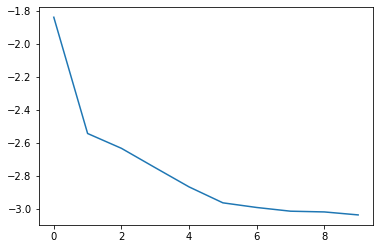

In [66]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), np.log10(loss_per_epoch))

**Se valida el modelo con los datos de entrenamiento y testing**

In [67]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1,1), trainPredict.reshape(-1,1)))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(-1,1), testPredict.reshape(-1,1)))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.06 RMSE


**Grafica de los datos de entrenamiento/predict**

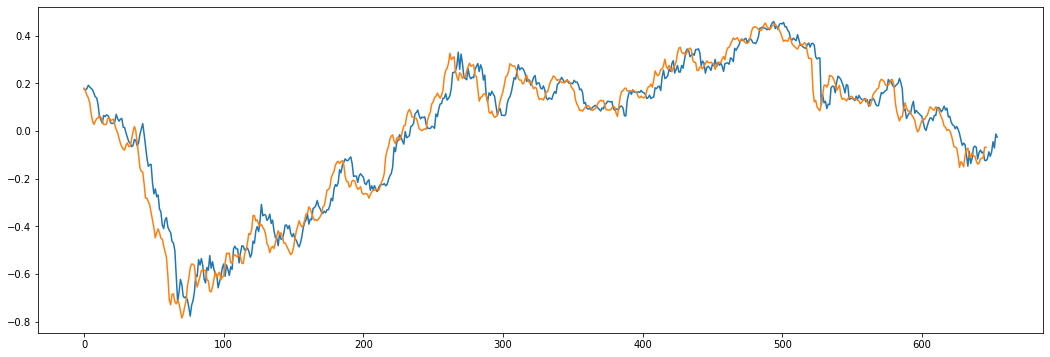

In [78]:
fig = plt.figure(figsize=(18,6))

plt.plot(train.values)
plt.plot(trainPredict)
plt.show()

**Grafica de los datos de testing/Predict**

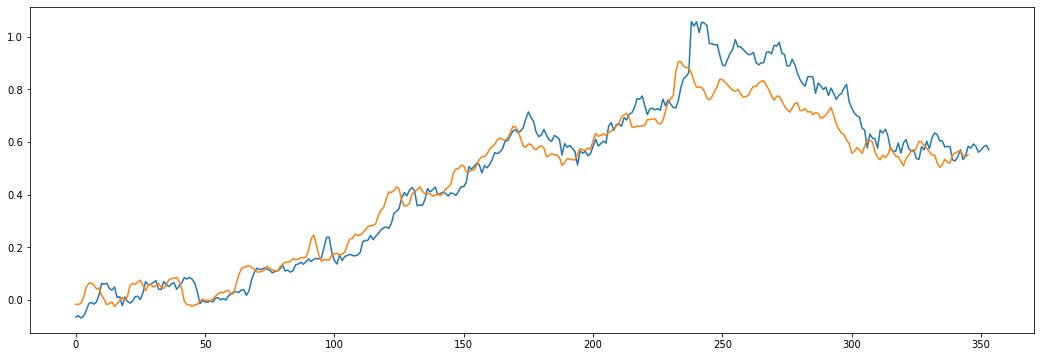

In [75]:
fig = plt.figure(figsize=(18,6))

plt.plot(test.values)
plt.plot(testPredict)
plt.show()

Luego de realizar la red neuronal, evidenciamos que el comportamiento que tiene es mucho más ajustado a la tendencia que obtuvimos por medio del modelo de AutoArima, lo que lo convierte en una solución más potente. Adicionalmente se evidencia que para los datos de entreanamiento se ve una curva muy señida con respecto a la de predicción lo que indica un Overtifiting del modelo en ese caso, pero que da un muy buen resultado cual se evalua el modelo con relación a los datos de test.

## Grafica Completa

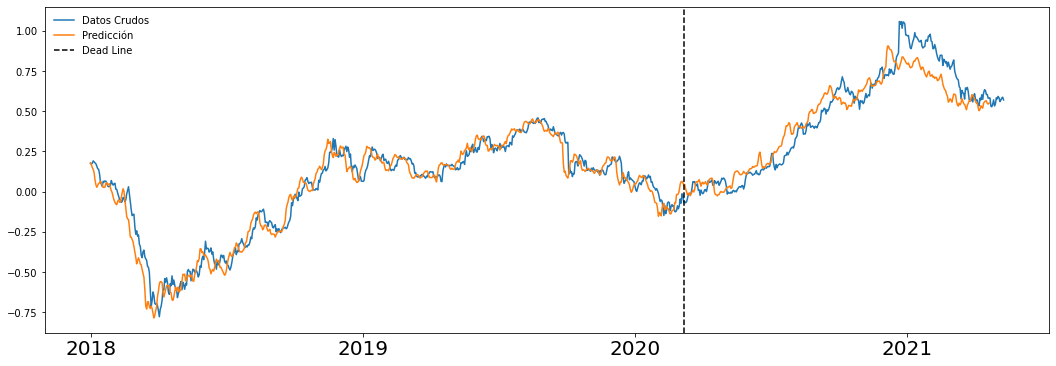

In [81]:
raw_data = np.concatenate([train.values,test.values]) 
predict_data = np.concatenate([trainPredict,testPredict]) 

fig = plt.figure(figsize=(18,6))
plt.plot(raw_data,label = 'Datos Crudos')
plt.plot(predict_data,label = "Predicción")
plt.axvline(x=len(train.values),color="black", linestyle="--", label = "Dead Line")
plt.legend(loc='upper left', frameon=False)
plt.xticks(range(1,1200,300), ['2018','2019','2020','2021'], fontsize=20)
plt.savefig("raw_vs_predict.jpg", bbox_inches='tight')
plt.show()

## Guardar Modelo entrenado

In [82]:
joblib.dump(model, 'modelo_bitcoin.pkl') # Guardo el modelo.

INFO:tensorflow:Assets written to: ram://b580c5c4-b1b7-410b-8064-6dbb9f07d2d4/assets


INFO:tensorflow:Assets written to: ram://b580c5c4-b1b7-410b-8064-6dbb9f07d2d4/assets


['modelo_bitcoin.pkl']